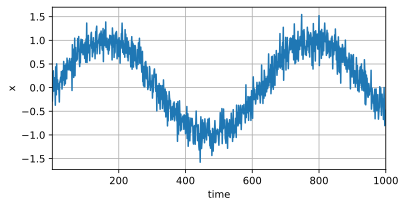

In [21]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

T = 1000
time = torch.arange(1, 1 + T, dtype=torch.float32)
x = torch.sin(.01 * time) + torch.normal(0, .2, (T, ))
d2l.plot(time, x, 'time', 'x', xlim=(1, 1000), figsize=(6, 3))

In [22]:
tau = 4
features = torch.zeros((T - tau, tau))
for i in range(tau):
    features[:, i] = x[i: T - tau + i]
labels = x[tau:].reshape((-1, 1))

batch_size, n_train = 16, 600
train_iter = d2l.load_array((features[:n_train], labels[:n_train]),
                    batch_size, is_train=True)

In [23]:
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_uniform_(m.weight)

def get_net():
    net = nn.Sequential(nn.Linear(4, 10),
                        nn.ReLU(),
                        nn.Linear(10, 1))
    net.apply(init_weights)
    return net

loss = nn.MSELoss(reduction='none')

In [28]:
def train(net, train_iter, loss, epochs, lr):
    trainer = torch.optim.Adam(net.parameters(), lr)
    for epoch in range(epochs):
        for x, y in train_iter:
            trainer.zero_grad()
            l = loss(net(x), y)
            l.sum().backward()
            trainer.step()
        print(f'epoch {epoch + 1}, loss:{d2l.evaluate_loss(net, train_iter, loss):.5f}')

net = get_net()
train(net, train_iter, loss, 10, .01)

epoch 1, loss:0.05934
epoch 2, loss:0.04985
epoch 3, loss:0.05064
epoch 4, loss:0.04817
epoch 5, loss:0.04810
epoch 6, loss:0.04810
epoch 7, loss:0.04766
epoch 8, loss:0.04753
epoch 9, loss:0.04805
epoch 10, loss:0.04839


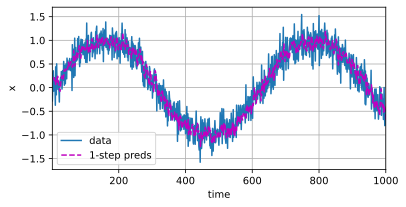

In [29]:
""" 单步预测 """
onestep_preds = net(features)
d2l.plot([time, time[tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy()], 'time', 'x', 
        legend=['data', '1-step preds'], xlim=[1, 1000], figsize=(6, 3))

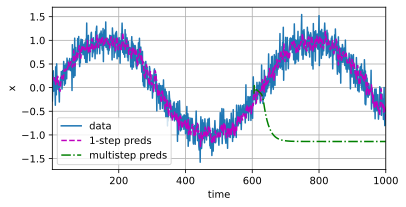

In [31]:
# k步预测
multistep_preds = torch.zeros(T)
multistep_preds[:n_train + tau] = x[:n_train + tau]
for i in range(n_train + tau, T):
    multistep_preds[i] = net(multistep_preds[i - tau:i].reshape((1, -1)))

d2l.plot([time, time[tau:], time[n_train + tau:]],
        [x.detach().numpy(), onestep_preds.detach().numpy(),
        multistep_preds[n_train + tau:].detach().numpy()], 'time', 'x', 
        legend=['data', '1-step preds', 'multistep preds'],
        xlim=[1, 1000], figsize=(6, 3))

In [34]:
a = torch.arange(16).reshape((2, 2, 4))
a, a.reshape(-1)

(tensor([[[ 0,  1,  2,  3],
          [ 4,  5,  6,  7]],
 
         [[ 8,  9, 10, 11],
          [12, 13, 14, 15]]]),
 tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15]))

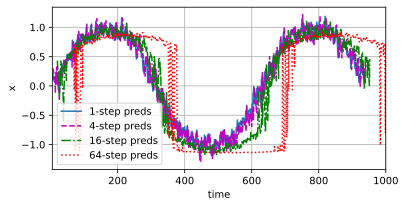

In [35]:
max_steps = 64
features = torch.zeros((T - tau - max_steps + 1, tau + max_steps))
for i in range(tau):
    features[:, i] = x[i:i + T - tau - max_steps + 1]
for i in range(tau, tau + max_steps):
    features[:, i] = net(features[:, i - tau:i]).reshape(-1)

steps = [1, 4, 16, 64]
d2l.plot([time[tau + i - 1:T - max_steps + i] for i in steps],
        [features[:, (tau + i - 1)].detach().numpy() for i in steps],
        'time', 'x',
        legend=[f'{i}-step preds' for i in steps], xlim=[5, 1000], figsize=(6, 3))